## Offensive Language Identification

This is the task 'b' in Task 6: OffensEval: Identifying and Categorizing Offensive Language in Social Media in SemEval 2019. We have explored how a RNN with attention + cyclic learning rate can be used in automatic categorization of offense types.. 

In [1]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import concatenate
from keras.callbacks import *

Using TensorFlow backend.


Loading training and testing sets

In [2]:
# Filter the non offensive posts in the training set
train = pd.read_csv("Data/training/offenseval-training-v1.tsv", sep='\t')
train = train.loc[train['subtask_a'] == 'OFF']

test_tweets = pd.read_csv("Data/testing/testset-taskb.tsv", sep='\t')
test_labels = pd.read_csv("Data/testing/labels_test-b.csv", header=-1, names = ["id", "subtask_b"])

test = pd.merge(test_tweets, test_labels, on=['id','id'])
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

Train shape :  (4400, 5)
Test shape :  (240, 3)


Converting the texts to lower case since the embedding model only has lower case words

In [3]:
train["tweet"] = train["tweet"].str.lower()
test["tweet"] = test["tweet"].str.lower()

Removing the punctuation marks

In [4]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

def clean_text(x):

    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x


train["tweet"] = train["tweet"].apply(lambda x: clean_text(x))
test["tweet"] = test["tweet"].apply(lambda x: clean_text(x))

In [5]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = None # how many unique words to use (i.e num rows in embedding vector)
maxlen = 72 # max number of words in a question to use #99.99%

## fill up the missing values
X = train["tweet"].fillna("_na_").values
X_test = test["tweet"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features, filters='')
tokenizer.fit_on_texts(list(X))

X = tokenizer.texts_to_sequences(X)
X_test = tokenizer.texts_to_sequences(X_test)

## Pad the sentences 
X = pad_sequences(X, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

## Get the target values
Y = train['subtask_b'].values

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le.fit(Y)
encoded_Y = le.transform(Y)
encoded_Y

array([1, 0, 1, ..., 0, 0, 1])

Preparing the embedding matrix

In [7]:
word_index = tokenizer.word_index
max_features = len(word_index)+1
def load_glove(word_index):
    EMBEDDING_FILE = '/data/glove/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if o.split(" ")[0] in word_index)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 
    
def load_fasttext(word_index):    
    EMBEDDING_FILE = '/data/fasttext/crawl-300d-2M-subword.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100 and o.split(" ")[0] in word_index )

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    embedding_matrix = np.random.normal(emb_mean, emb_std, (max_features, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix

Implementation of the Attention Layer

In [8]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
    
    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

Implementation of the Cyclic learning rate

In [9]:
# https://www.kaggle.com/hireme/fun-api-keras-f1-metric-cyclical-learning-rate/code

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr()) 

    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

def f1(y_true, y_pred):
    '''
    metric from here 
    https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
    '''
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Implementing the model with Bi directional GRU and LSTM with self attention on each. It is followed by a average pooling and max pooling layers. 

In [10]:
def model_lstm_atten():
    
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
    x = SpatialDropout1D(0.1)(x)
    x = Bidirectional(LSTM(40, return_sequences=True))(x)
    y = Bidirectional(GRU(40, return_sequences=True))(x)
    
    atten_1 = Attention(maxlen)(x) # skip connect
    atten_2 = Attention(maxlen)(y)
    avg_pool = GlobalAveragePooling1D()(y)
    max_pool = GlobalMaxPooling1D()(y)
    
    conc = concatenate([atten_1, atten_2, avg_pool, max_pool])
    conc = Dense(16, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)    

    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])
    
    return model

In [11]:
# https://www.kaggle.com/strideradu/word2vec-and-gensim-go-go-go
def train_pred(model, train_X, train_y, val_X, val_y, epochs=2, callback=None):
    for e in range(epochs):
        model.fit(train_X, train_y, batch_size=64, epochs=20, validation_data=(val_X, val_y), callbacks = callback, verbose=0)
        pred_val_y = model.predict([val_X], batch_size=64, verbose=0)

        best_score = metrics.f1_score(val_y, (pred_val_y > 0.33).astype(int))
        print("Epoch: ", e, "-    Val F1 Score: {:.4f}".format(best_score))

    pred_test_y = model.predict([X_test], batch_size=64, verbose=1)
    print('=' * 60)
    return pred_val_y, pred_test_y, best_score

Preparing the embedding matrix, Only glove is used here.

In [12]:
embedding_matrix_1 = load_glove(word_index)

In [13]:
embedding_matrix = embedding_matrix_1
np.shape(embedding_matrix)

(10629, 300)

In [14]:
# https://www.kaggle.com/ryanzhang/tfidf-naivebayes-logreg-baseline

def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

Model training

In [15]:
DATA_SPLIT_SEED = 2018
clr = CyclicLR(base_lr=0.001, max_lr=0.002,
               step_size=300., mode='exp_range',
               gamma=0.99994)

train_meta = np.zeros(Y.shape)
test_meta = np.zeros(X_test.shape[0])
splits = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=DATA_SPLIT_SEED).split(X, encoded_Y))
for idx, (train_idx, valid_idx) in enumerate(splits):
        X_train = X[train_idx]
        y_train = encoded_Y[train_idx]
        X_val = X[valid_idx]
        y_val = encoded_Y[valid_idx]
        model = model_lstm_atten()
        pred_val_y, pred_test_y, best_score = train_pred(model, X_train, y_train, X_val, y_val, epochs = 8, callback = [clr,])
        train_meta[valid_idx] = pred_val_y.reshape(-1)
        test_meta += pred_test_y.reshape(-1) / len(splits)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch:  0 -    Val F1 Score: 0.2723
Epoch:  1 -    Val F1 Score: 0.1885
Epoch:  2 -    Val F1 Score: 0.2476
Epoch:  3 -    Val F1 Score: 0.2619
Epoch:  4 -    Val F1 Score: 0.2727
Epoch:  5 -    Val F1 Score: 0.2647
Epoch:  6 -    Val F1 Score: 0.2424
Epoch:  7 -    Val F1 Score: 0.2371
240/240 [==============================] - 0s 291us/step
Epoch:  0 -    Val F1 Score: 0.2363
Epoch:  1 -    Val F1 Score: 0.2839
Epoch:  2 -    Val F1 Score: 0.2745
Epoch:  3 -    Val F1 Score: 0.2319
Epoch:  4 -    Val F1 Score: 0.2569
Epoch:  5 -    Val F1 Score: 0.3258
Epoch:  6 -    Val F1 Score: 0.3017
Epoch:  7 -    Val F1 Score: 0.2642
240/240 [==============================] - 0s 292us/st

Predictions for test

In [19]:
y_te = (np.array(test_meta) > 0.33).astype(np.int)

### Coinfusion Matrix

In [20]:
from sklearn.metrics import confusion_matrix

test['predictions'] = le.inverse_transform(y_te)
tn, fp, fn, tp = confusion_matrix(test["subtask_b"], test['predictions']).ravel()
(tn, fp, fn, tp)

(200, 13, 15, 12)

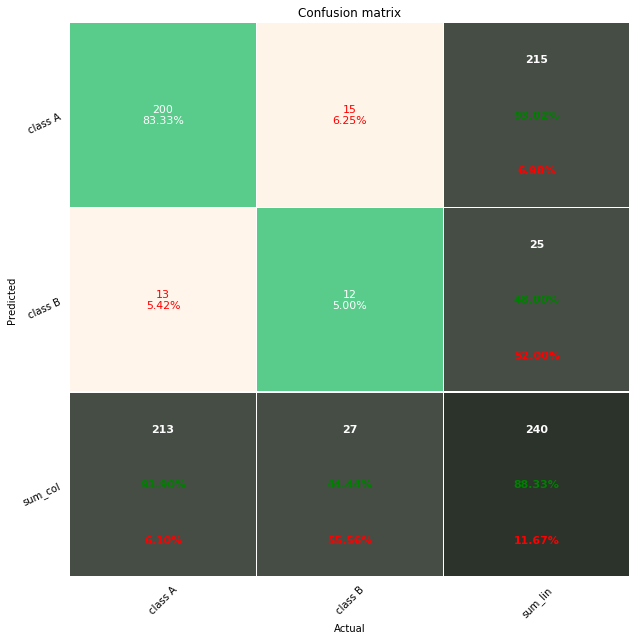

In [21]:
from visualization.confusion_matrix_pretty_print import plot_confusion_matrix_from_data

columns = []
annot = True
cmap = 'Oranges'
fmt = '.2f'
lw = 0.5
cbar = False
show_null_values = 2
pred_val_axis = 'y'
# size::
fz = 12;
figsize = [9, 9];
if len(test["subtask_b"]) > 10:
    fz = 9;
    figsize = [14, 14];
plot_confusion_matrix_from_data(test["subtask_b"], test['predictions'], columns,
                                    annot, cmap, fmt, fz, lw, cbar, figsize, show_null_values, pred_val_axis)

### Accuracy

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(test["subtask_b"], test['predictions'])

0.8833333333333333